In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import learning_curve

In [2]:
data = pd.read_csv('forestfires.csv')

#### Data Preprocessing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [5]:
#Handled Missing Values
missing_values = data.isnull().sum()
print(missing_values)

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


In [6]:
# Initialize LabelEncoder
label_encoder_month = LabelEncoder()
label_encoder_day = LabelEncoder()

# Apply Label Encoding
data['month'] = label_encoder_month.fit_transform(data['month'])
data['day'] = label_encoder_day.fit_transform(data['day'])

In [7]:
# Normalization
features_to_normalize = ['DC', 'FFMC', 'ISI', 'DMC', 'temp', 'RH', 'wind', 'rain', 'area']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler
data[features_to_normalize] = scaler.fit_transform(data[features_to_normalize])

In [8]:
# Define bins and labels for discretization
bins = [0, data['area'].median(), data['area'].quantile(0.75), 1]
labels = ['Small Burn', 'Moderate Burn', 'Large Burn']  # Class labels

# Create a new column with discretized categories
data['area_class'] = pd.cut(data['area'], bins=[-1] + bins, labels=['No Burn'] + labels)

In [9]:
print(data.head())

   X  Y  month  day      FFMC       DMC        DC       ISI      temp  \
0  7  5      7    0  0.870968  0.086492  0.101325  0.090909  0.192926   
1  7  4     10    5  0.927742  0.118194  0.775419  0.119430  0.508039   
2  7  4     10    2  0.927742  0.146795  0.796294  0.119430  0.398714   
3  8  6      7    0  0.941935  0.110958  0.081623  0.160428  0.196141   
4  8  6      7    3  0.910968  0.172984  0.110590  0.171123  0.295820   

         RH      wind     rain  area area_class  
0  0.423529  0.700000  0.00000   0.0    No Burn  
1  0.211765  0.055556  0.00000   0.0    No Burn  
2  0.211765  0.100000  0.00000   0.0    No Burn  
3  0.964706  0.400000  0.03125   0.0    No Burn  
4  0.988235  0.155556  0.00000   0.0    No Burn  


In [10]:
# Statistical Summary
num_data = data.copy()
num_data = num_data.drop(num_data.columns[[13]], axis=1)

summary = data.describe().T  # Transpose for better readability
summary['median'] = num_data.median()  # Add median to the summary
summary_stats = summary[['mean', 'median', 'std']]
summary_stats

,mean,median,std
X,4.669246,4.000000,2.313778
Y,4.299807,4.000000,1.229900
month,5.758221,6.000000,4.373275
day,2.736944,3.000000,1.925061
FFMC,0.928318,0.940645,0.071227
DMC,0.378264,0.369400,0.220698
DC,0.633329,0.769673,0.290918
ISI,0.160814,0.149733,0.081274
temp,0.536629,0.549839,0.186708
RH,0.344567,0.317647,0.191970


#### Visualization

##### Distribution of Features

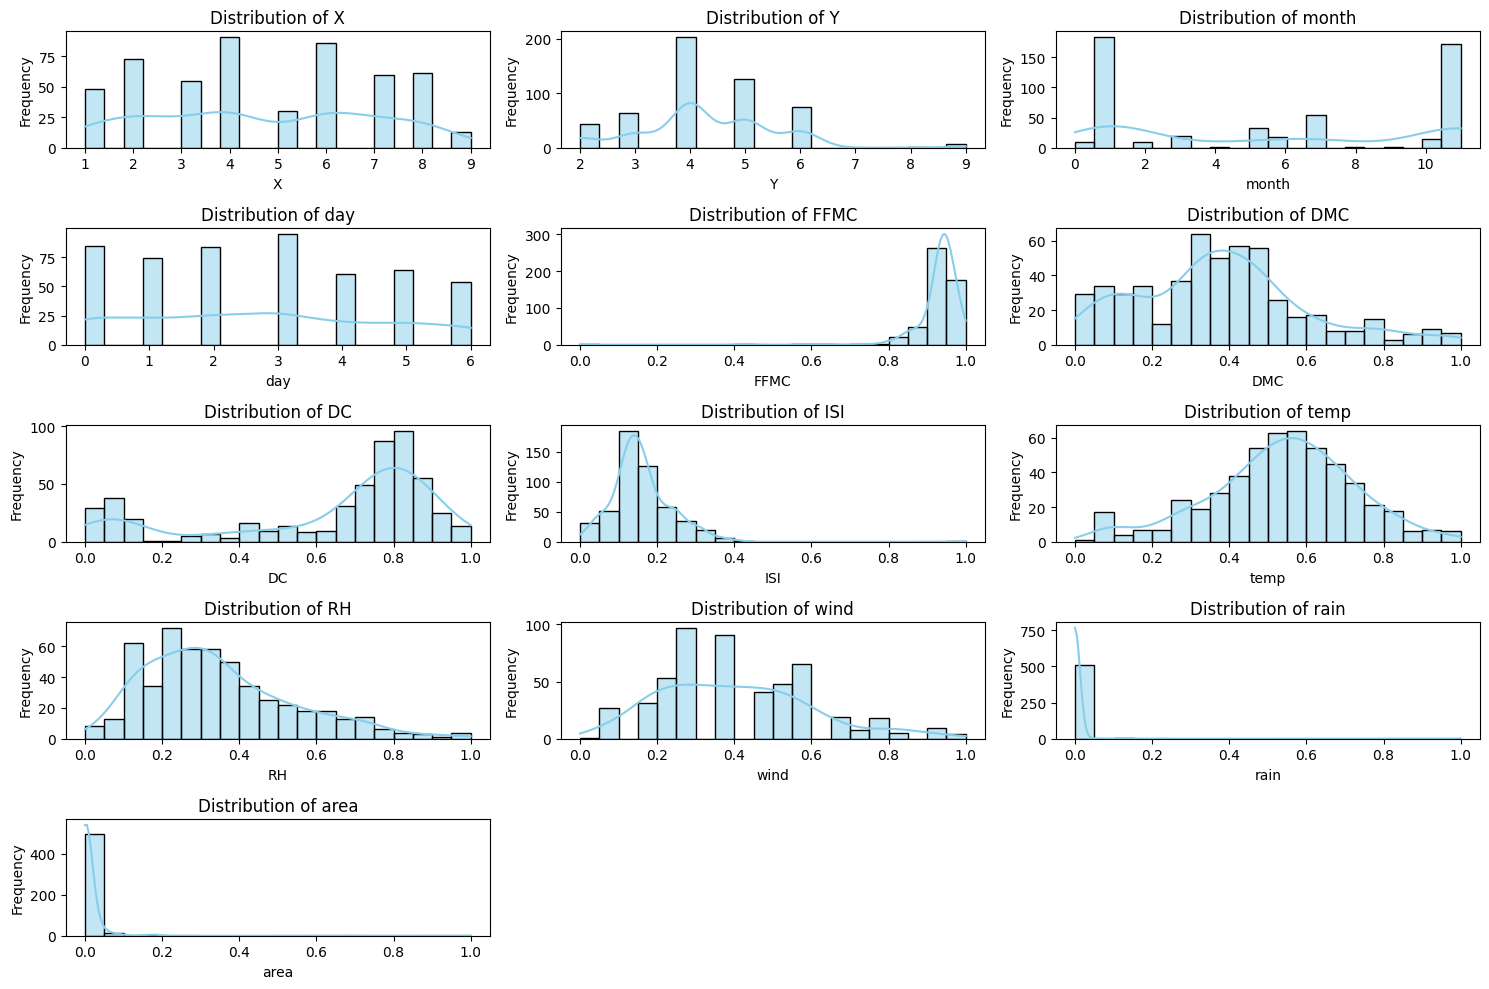

In [11]:
# Set up the plotting grid
num_cols = data.select_dtypes(include=['float64', 'int64']).columns  # Select numerical columns
n_cols = 3  # Number of plots per row
n_rows = -(-len(num_cols) // n_cols)  # Calculate rows needed for the grid (ceiling division)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each numerical column
for i, col in enumerate(num_cols):
    sns.histplot(data[col], kde=True, bins=20, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Frequency")

# Remove extra subplots if there are fewer columns
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

This graph illustrates the distribution of features, highlighting aspects like skewness or normality.

##### Boxplot of Features

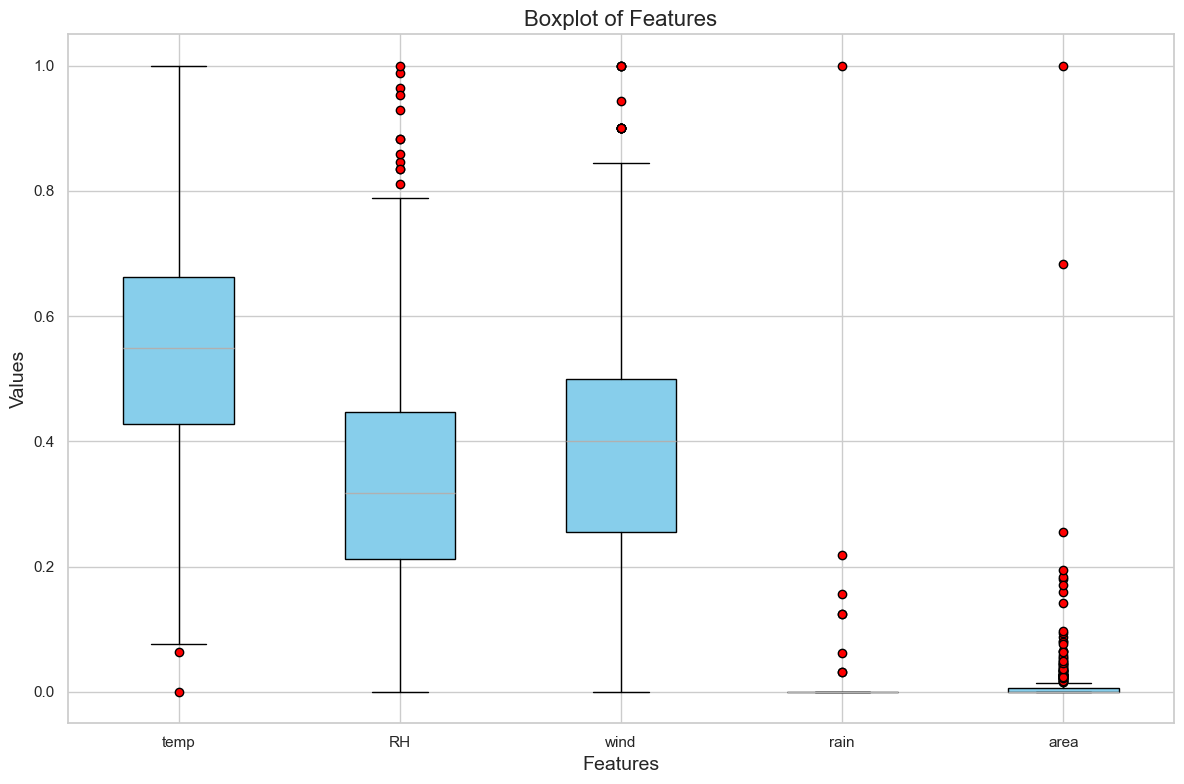

In [12]:
# Set the style for better visuals
sns.set(style="whitegrid")

# Create the boxplot for specific features
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
data[['temp', 'RH', 'wind', 'rain', 'area']].boxplot(
    patch_artist=True,  # Fill the boxes with color
    boxprops=dict(facecolor='skyblue', color='black'),  # Box color
    whiskerprops=dict(color='black'),  # Whisker color
    flierprops=dict(markerfacecolor='red', marker='o', markersize=6),  # Outlier color and style
    capprops=dict(color='black'),  # Cap color
)

# Add title and axis labels
plt.title("Boxplot of Features", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Values", fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

This plot reveals the presence of outliers distributed across each factor. Due to the varying values, the boxplot displays distinct plots for each feature. Notably, rain and area exhibit smaller values compared to temperature, RH, and wind.

##### Scatterplot of temperature and humidity VS area

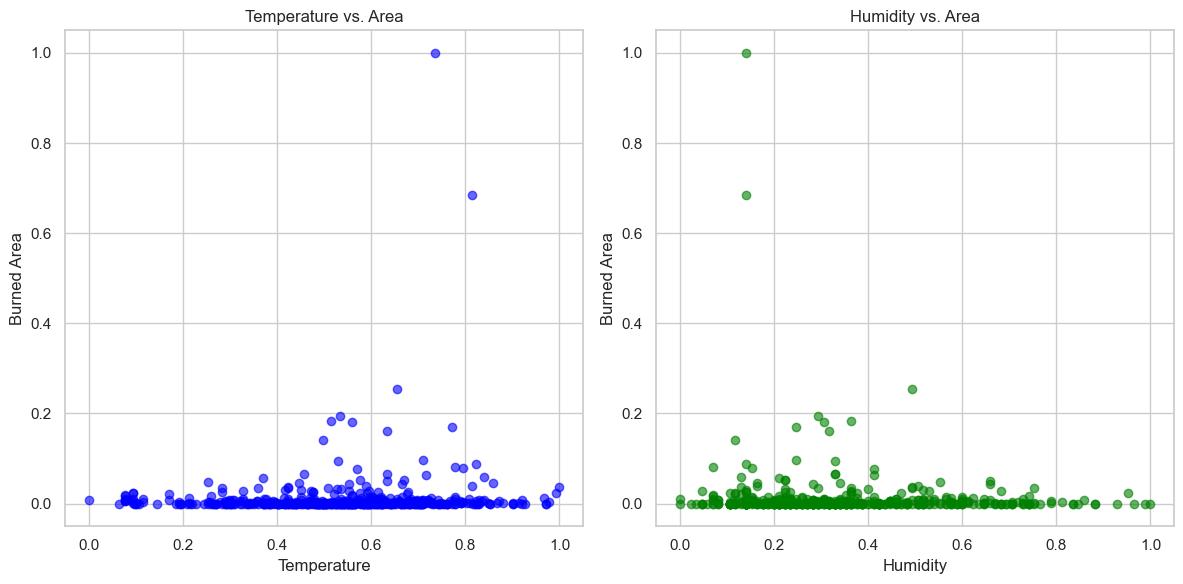

In [13]:
# Scatter plots for temperature and humidity vs. area
plt.figure(figsize=(12, 6))

# Temperature vs Area
plt.subplot(1, 2, 1)
plt.scatter(data['temp'], data['area'], alpha=0.6, color='blue')
plt.title('Temperature vs. Area')
plt.xlabel('Temperature')
plt.ylabel('Burned Area')

# Humidity vs Area
plt.subplot(1, 2, 2)
plt.scatter(data['RH'], data['area'], alpha=0.6, color='green')
plt.title('Humidity vs. Area')
plt.xlabel('Humidity')
plt.ylabel('Burned Area')

plt.tight_layout()
plt.show()

##### Correlation Matrix

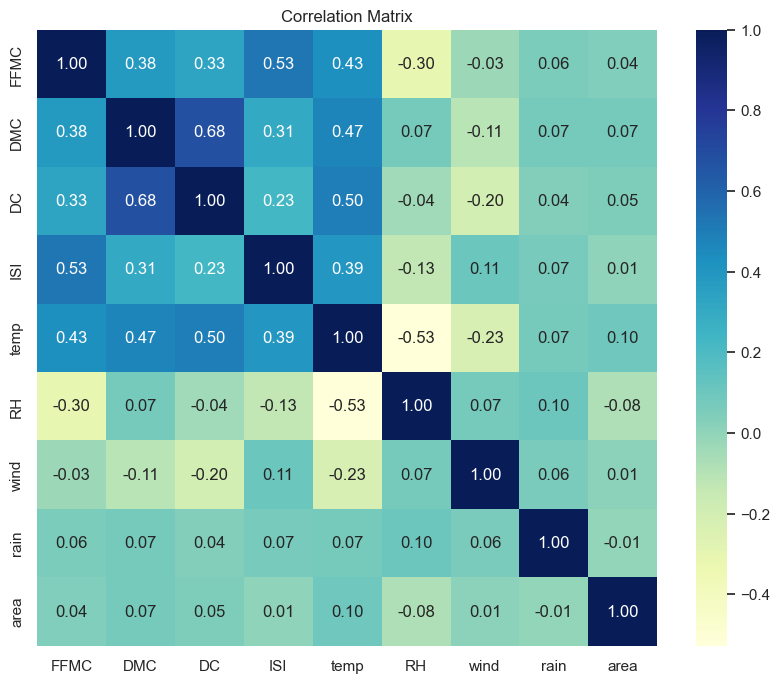

In [14]:
# Compute correlation matrix
corr_data = num_data.copy()
corr_data = corr_data.drop(corr_data.columns[[0,1,2,3]], axis=1)
correlation_matrix = corr_data.corr()

# Assuming correlation_matrix is already computed
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")  # Change 'viridis' to your preferred colormap
plt.title("Correlation Matrix")
plt.show()

In [15]:
correlation_with_target = correlation_matrix['area'].sort_values(ascending=False)
print("Features most correlated with area:")
print(correlation_with_target)

Features most correlated with area:
area    1.000000
temp    0.097844
DMC     0.072994
DC      0.049383
FFMC    0.040122
wind    0.012317
ISI     0.008258
rain   -0.007366
RH     -0.075519
Name: area, dtype: float64


Based on the heatmap, we can observe that the area is not significantly correlated with temperature and humidity. In contrast, temperature shows a stronger relationship with the Dryness Code, Duff Moisture Code, Fine Fuel Moisture Code, and Initial Spread Index.

##### Class Distribution of Target Variable

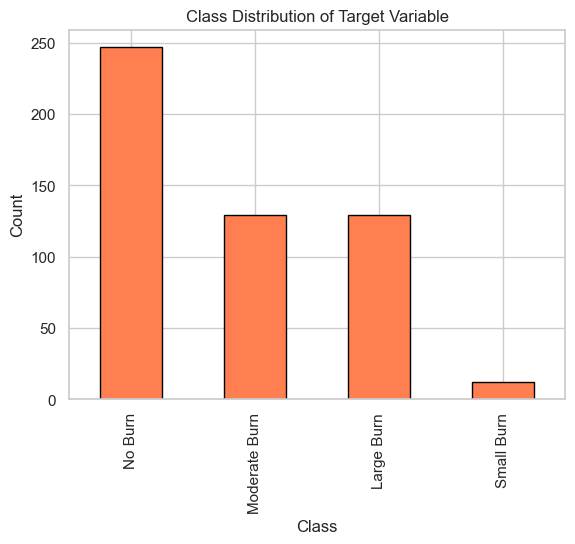

In [16]:
# Plot class distribution
data['area_class'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title("Class Distribution of Target Variable")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

We can see that there are the most forest which has not burned in the past.

##### Model Training (Before Tuning)

Regression
- Linear Regression
- Random Forest

Classification
- KNN
- Random Forest Model

In [17]:
# Define target variable and features
X_reg = data.drop(columns=['area', 'area_class']) 
y_reg = data['area']

X_class = data.drop(columns=['area', 'area_class'])  # Assuming 'area' is the target variable
y_class = data['area_class']

# Split the dataset into training and test sets (80%-20%)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (413, 12)
X_test shape: (104, 12)
y_train shape: (413,)
y_test shape: (104,)


In [18]:
# Linear Regression Model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_reg, y_train_reg)
y_pred_lin_reg = lin_reg_model.predict(X_test_reg)

# Random Forest Regressor Model
rf_reg_model = RandomForestRegressor(random_state=42)
rf_reg_model.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg_model.predict(X_test_reg)

# Evaluation Metrics for Regression
# Linear Regression
mse_lin = mean_squared_error(y_test_reg, y_pred_lin_reg)
mae_lin = mean_absolute_error(y_test_reg, y_pred_lin_reg)
r2_lin = r2_score(y_test_reg, y_pred_lin_reg)

# Random Forest Regressor
mse_rf = mean_squared_error(y_test_reg, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf_reg)
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)

# Display Results
print("Linear Regression Performance:")
print(f"MSE: {mse_lin:.2f}, MAE: {mae_lin:.2f}, R^2: {r2_lin:.2f}")
print("\nRandom Forest Regressor Performance:")
print(f"MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, R^2: {r2_rf:.2f}")

Linear Regression Performance:
MSE: 0.01, MAE: 0.02, R^2: 0.00

Random Forest Regressor Performance:
MSE: 0.01, MAE: 0.02, R^2: -0.02


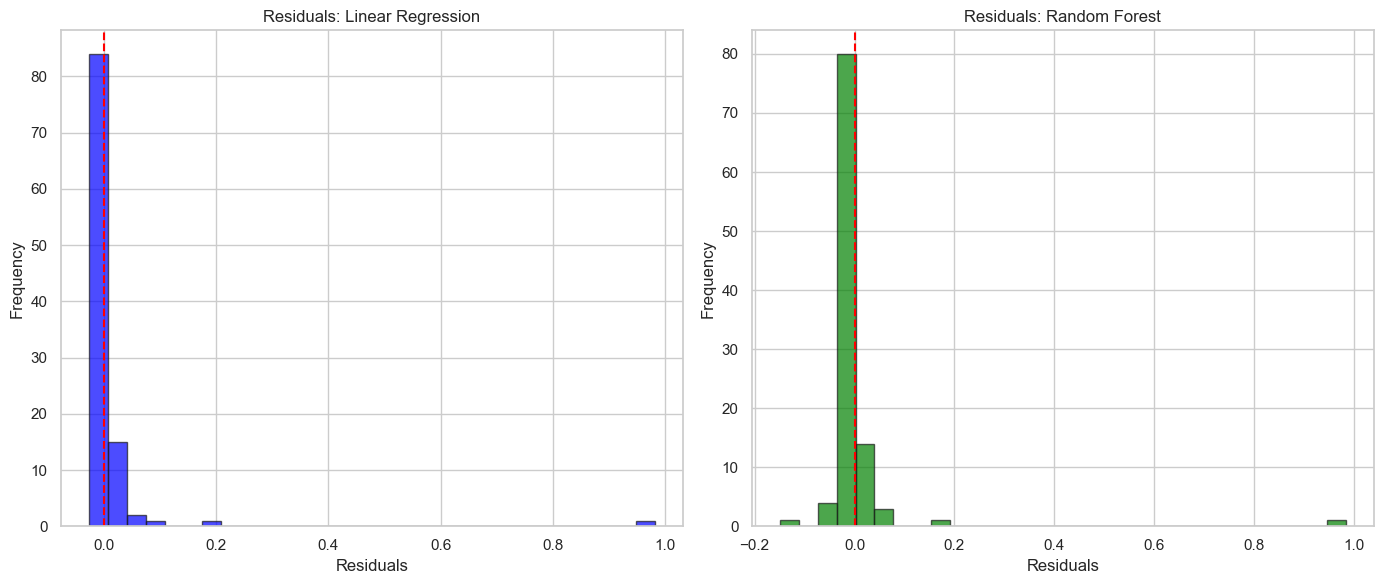

In [19]:
# Residuals
residuals_lin = y_test_reg - y_pred_lin_reg
residuals_rf = y_test_reg - y_pred_rf_reg

plt.figure(figsize=(14, 6))

# Linear Regression Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_lin, bins=30, alpha=0.7, edgecolor='k', color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residuals: Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Random Forest Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_rf, bins=30, alpha=0.7, edgecolor='k', color='green')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residuals: Random Forest')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

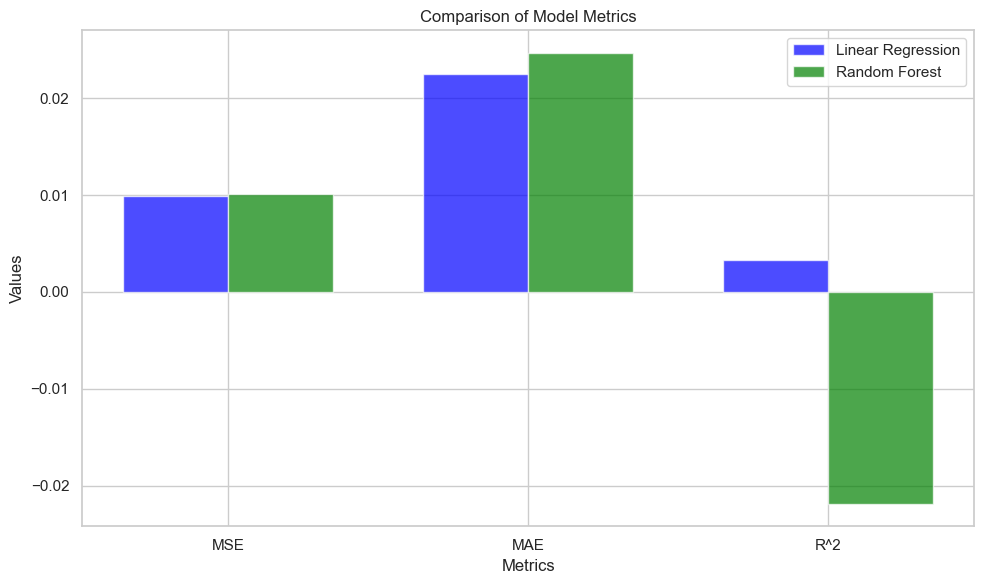

In [20]:
# Metrics
metrics = ['MSE', 'MAE', 'R^2']
lin_values = [mse_lin, mae_lin, r2_lin]
rf_values = [mse_rf, mae_rf, r2_rf]

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, lin_values, width, label='Linear Regression', color='blue', alpha=0.7)
plt.bar(x + width/2, rf_values, width, label='Random Forest', color='green', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Model Metrics')
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()

#### Observations
- MSE and MAE: Both models are making similar average errors, as indicated by the identical MSE and MAE values.
- R²: Both models are not performing well at all, with the Random Forest performing even worse than the linear regression. Neither model is effectively capturing the relationship between the features and the target variable.

In [21]:
# Split the dataset into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=5)
# Fit the model
knn_model.fit(X_train_class, y_train_class)

# Random Forest Classifier Model
rf_class_model = RandomForestClassifier(random_state=42)
rf_class_model.fit(X_train_class, y_train_class)

# Predictions
y_pred_knn = knn_model.predict(X_test_class)
y_pred_rf_class = rf_class_model.predict(X_test_class)

# Evaluation Metrics
# KNN
# Evaluate the model
accuracy_knn = accuracy_score(y_test_class, y_pred_knn)
precision_knn = precision_score(y_test_class, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test_class, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test_class, y_pred_knn, average='weighted')
roc_auc_knn = roc_auc_score(y_test_class, knn_model.predict_proba(X_test_class), multi_class='ovr', average='weighted')

# Random Forest Classifier
accuracy_rf = accuracy_score(y_test_class, y_pred_rf_class)
precision_rf = precision_score(y_test_class, y_pred_rf_class, average='weighted')
recall_rf = recall_score(y_test_class, y_pred_rf_class, average='weighted')
f1_rf = f1_score(y_test_class, y_pred_rf_class, average='weighted')
roc_auc_rf = roc_auc_score(y_test_class, rf_class_model.predict_proba(X_test_class), multi_class='ovr')

# Display results
print("KNN Performance:")
print(f"Accuracy: {accuracy_knn:.2f}, Precision: {precision_knn:.2f}, Recall: {recall_knn:.2f}, F1: {f1_knn:.2f}, ROC-AUC: {roc_auc_knn:.2f}")
print("\nRandom Forest Classifier Performance:")
print(f"Accuracy: {accuracy_rf:.2f}, Precision: {precision_rf:.2f}, Recall: {recall_rf:.2f}, F1: {f1_rf:.2f}, ROC-AUC: {roc_auc_rf:.2f}")


KNN Performance:
Accuracy: 0.44, Precision: 0.42, Recall: 0.44, F1: 0.43, ROC-AUC: 0.58

Random Forest Classifier Performance:
Accuracy: 0.48, Precision: 0.43, Recall: 0.48, F1: 0.44, ROC-AUC: 0.66


/Users/yuni/CSCI5502 data mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuni/CSCI5502 data mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Model Training (After Tuning)

- GridSearchCV

In [22]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_class, y_train_class)

# Best parameters found by GridSearchCV
print(f"Best hyperparameters: {grid_search.best_params_}")

# Best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_rf = best_rf_model.predict(X_test_class)

# Metrics for multiclass classification
accuracy = accuracy_score(y_test_class, y_pred_rf)

precision = precision_score(y_test_class, y_pred_rf, average='weighted')
recall = recall_score(y_test_class, y_pred_rf, average='weighted')
f1 = f1_score(y_test_class, y_pred_rf, average='weighted')

# For ROC-AUC, we need to use the predict_proba method
roc_auc = roc_auc_score(y_test_class, best_rf_model.predict_proba(X_test_class), multi_class='ovr')

# Print the results
print(f"Random Forest Hyperparameter Tuned Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END m

/Users/yuni/CSCI5502 data mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# Define the KNN model
knn_model = KNeighborsClassifier()

# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Try different odd values for n_neighbors
    'weights': ['uniform', 'distance'],  # Test uniform and distance weighting
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Different distance metrics
    'leaf_size': [20, 30, 40]  # The size of leaf in BallTree or KDTree
}

# Set up the grid search
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model with the best parameters found from grid search
grid_search.fit(X_train_class, y_train_class)

# Get the best parameters and best score
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

y_pred_knn = best_knn_model.predict(X_test_class)

accuracy = accuracy_score(y_test_class, y_pred_knn)
precision = precision_score(y_test_class, y_pred_knn, average='weighted')
recall = recall_score(y_test_class, y_pred_knn, average='weighted')
f1 = f1_score(y_test_class, y_pred_knn, average='weighted')
roc_auc = roc_auc_score(y_test_class, best_knn_model.predict_proba(X_test_class), multi_class='ovr')

print(f"Best KNN Hyperparameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.2f}")

# Print the results
print(f"KNN Hyperparameter Tuned Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Best KNN Hyperparameters: {'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best Cross-Validation Score: 0.42
KNN Hyperparameter Tuned Performance:
Accuracy: 0.41
Precision: 0.36
Recall: 0.41
F1: 0.38
ROC-AUC: 0.55


#### Observations  

**Regression model:** Both models have low MSE and low MAE, indicating they make relatively small errors. However, the R² values for both models suggest poor performance in terms of explaining the variance in the data, with the Random Forest Regressor performing slightly worse than Linear Regression.

**Classification model:** Random Forest is the better model for classification tasks based on higher precision, recall, F1-score, and ROC-AUC. It is more capable of capturing the underlying patterns and distinguishing between classes compared to KNN.

#### Conclusion
For regression, both models (Linear Regression and Random Forest Regressor) show poor performance, with R² values close to zero or negative. Additional feature engineering or different models might be needed. For classification, Random Forest outperforms KNN across all metrics (precision, recall, F1-score, and ROC-AUC), making it the more suitable model for this dataset.

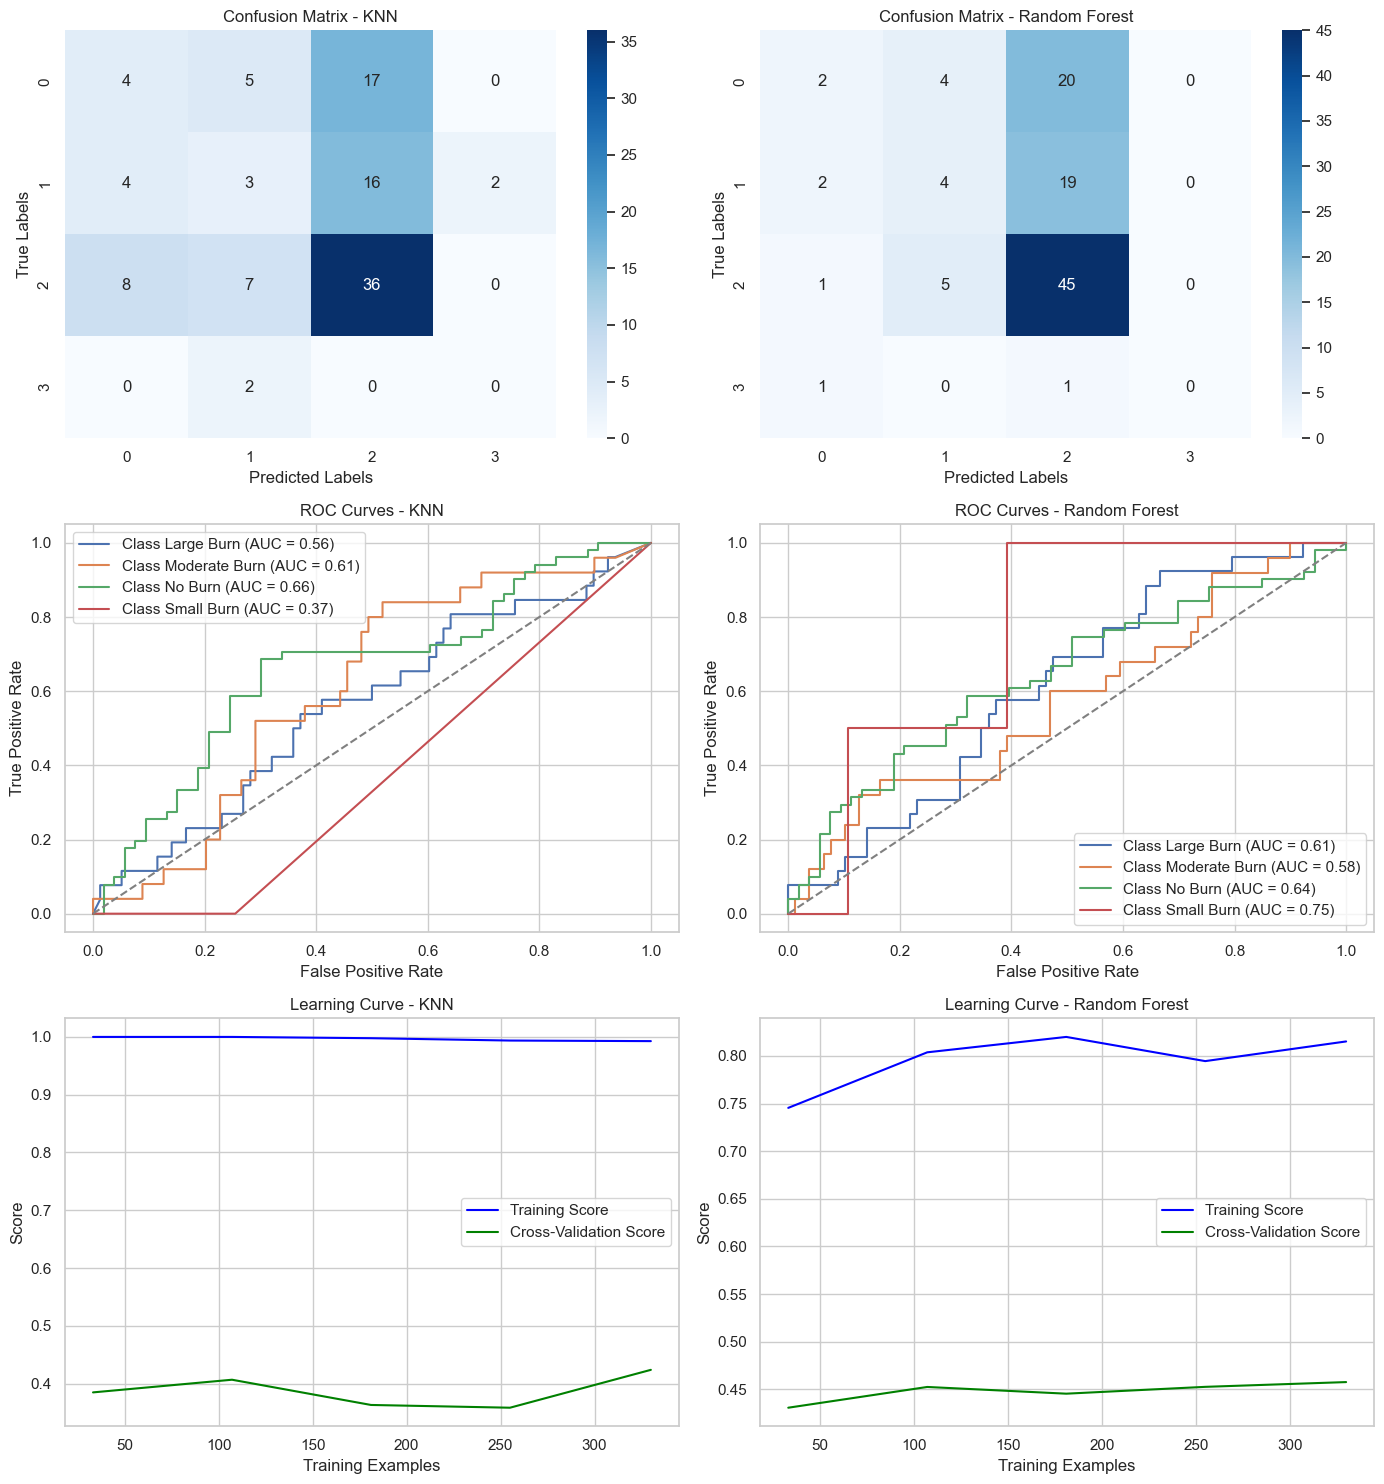

In [24]:
# Confusion Matrix Visualization
def plot_confusion_matrix(model_name, y_true, y_pred, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# ROC Curve Visualization
def plot_roc_curves(model_name, y_true, y_proba, ax):
    fpr = {}
    tpr = {}
    roc_auc = {}
    classes = np.unique(y_true)

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_true == cls, y_proba[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])
        ax.plot(fpr[cls], tpr[cls], label=f'Class {cls} (AUC = {roc_auc[cls]:.2f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_title(f'ROC Curves - {model_name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

# Learning Curve Visualization
def plot_learning_curve(estimator, title, X, y, ax, cv=None, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
    ax.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='green')
    ax.set_title(title)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend()

# Plotting Confusion Matrices
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Confusion Matrix for KNN
plot_confusion_matrix('KNN', y_test_class, y_pred_knn, axes[0, 0])

# Confusion Matrix for Random Forest
plot_confusion_matrix('Random Forest', y_test_class, y_pred_rf, axes[0, 1])

# Plotting ROC Curves
plot_roc_curves('KNN', y_test_class, best_knn_model.predict_proba(X_test_class), axes[1, 0])
plot_roc_curves('Random Forest', y_test_class, best_rf_model.predict_proba(X_test_class), axes[1, 1])

# Plotting Learning Curves
plot_learning_curve(best_knn_model, 'Learning Curve - KNN', X_train_class, y_train_class, axes[2, 0], cv=5)
plot_learning_curve(best_rf_model, 'Learning Curve - Random Forest', X_train_class, y_train_class, axes[2, 1], cv=5)

plt.tight_layout()
plt.show()


- The KNN model struggles with distinguishing between "Large Burn" and "No Burn" and poorly predicts "Small Burn."
- Random Forest performs better than KNN, especially in predicting the "No Burn" class. However, it still struggles to classify "Large Burn" and "Moderate Burn" correctly, with heavy bias toward "No Burn."

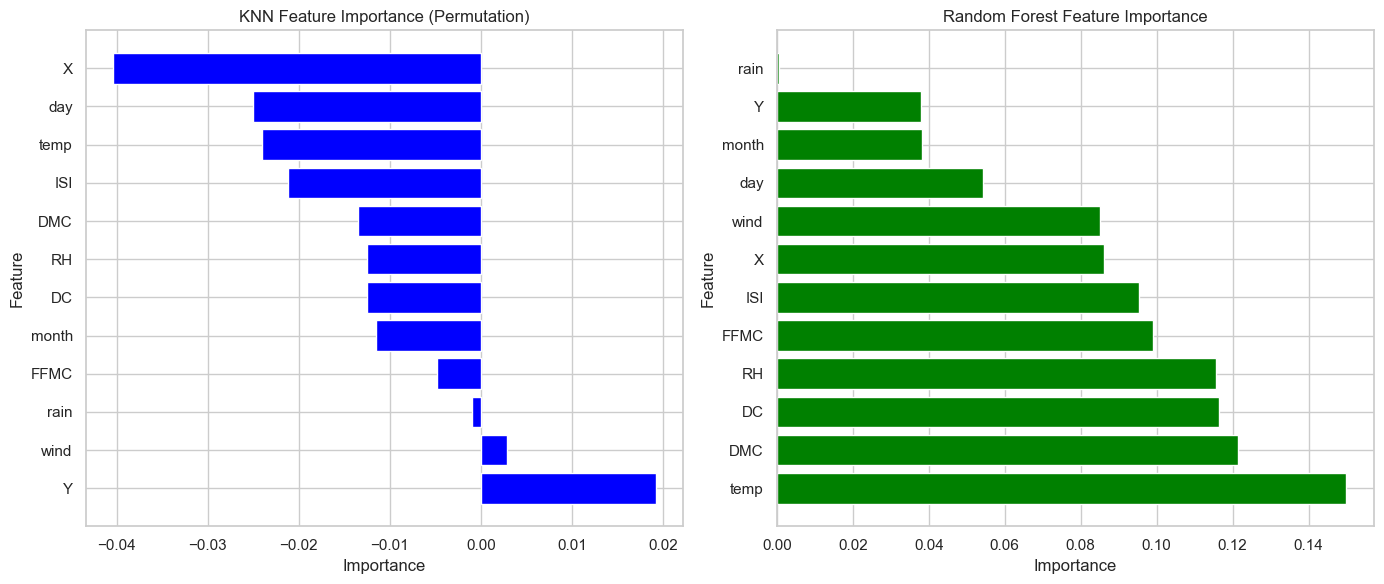

KNN Feature Importance:
   Feature  Importance
1        Y    0.019231
10    wind    0.002885
11    rain   -0.000962
4     FFMC   -0.004808
2    month   -0.011538
6       DC   -0.012500
9       RH   -0.012500
5      DMC   -0.013462
7      ISI   -0.021154
8     temp   -0.024038
3      day   -0.025000
0        X   -0.040385

Random Forest Feature Importance:
   Feature  Importance
8     temp    0.149757
5      DMC    0.121507
6       DC    0.116516
9       RH    0.115645
4     FFMC    0.099069
7      ISI    0.095221
0        X    0.086222
10    wind    0.085110
3      day    0.054360
2    month    0.038277
1        Y    0.037919
11    rain    0.000399


In [25]:
# Evaluate permutation importance for KNN
result = permutation_importance(best_knn_model, X_test, y_test_class, n_repeats=10, random_state=42)
importance_knn = result.importances_mean
importance_df_knn = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_knn})
importance_df_knn = importance_df_knn.sort_values(by='Importance', ascending=False)

# Get feature importances from the trained Random Forest model
feature_importances_rf = best_rf_model.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Create a figure with 1 row and 2 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot KNN feature importance
axes[0].barh(importance_df_knn['Feature'], importance_df_knn['Importance'], color='blue')
axes[0].set_title('KNN Feature Importance (Permutation)')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')

# Plot Random Forest feature importance
axes[1].barh(importance_df_rf['Feature'], importance_df_rf['Importance'], color='green')
axes[1].set_title('Random Forest Feature Importance')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

# Show the combined plot
plt.tight_layout()
plt.show()

# Display the feature importance tables
print("KNN Feature Importance:")
print(importance_df_knn)
print("\nRandom Forest Feature Importance:")
print(importance_df_rf)


**KNN Feature Importance:**
- From the KNN model, the most important features are Dryness Code and Duff Moisture Code, with importance values of 0.0538 and 0.0490, respectively. These features relate to dryness and moisture levels in the forest environment, which are crucial in predicting fire behavior.
- Other features, such as month, temp, RH, wind, and rain, have zero or negligible importance, indicating that in this model, these environmental factors did not contribute significantly to the prediction of fire severity or occurrence.
- The negative importance values for features like X, Y, and day suggest that these features might not be relevant for the model and could potentially introduce noise.  

**Random Forest Feature Importance:**
- The Random Forest model assigns higher importance to temp, DMC, DC, and RH. For example, temp has an importance score of 0.1497, indicating that temperature plays a significant role in predicting fire behavior, which is intuitive since higher temperatures typically increase the likelihood of fires.

**Comparison:**
- While both KNN and Random Forest models agree on the importance of moisture-related features (DMC, DC, FFMC) and spread-related features (ISI, wind), the Random Forest model gives more weight to temp, RH, and X, which may suggest that temperature, humidity, and spatial coordinates are important in predicting fire severity, whereas the KNN model does not prioritize them as highly.

**Insights:**
- Both models reveal that moisture levels and temperature are key factors in predicting fire severity or occurrence. This aligns with what is expected in real-world fire behavior studies, where dry and hot conditions create a higher likelihood for fire outbreaks.
- The models also highlight the importance of wind speed and fuel moisture in determining how quickly a fire spreads. These factors are critical in fire management, as they influence firefighting strategies and resource allocation.

**Potential Real-World Applications:**
- The models can be used to predict the severity of forest fires based on environmental conditions like temperature, humidity, and dryness. This could help in issuing early warnings and preparing firefighting teams for more severe fires.
- Understanding which features contribute most to fire behavior (e.g., temperature, wind, and fuel moisture) can aid in creating more effective firefighting strategies. For example, higher temperatures and dry conditions may require aggressive suppression efforts, while areas with high humidity may require different approaches.
